In [1]:
%matplotlib inline
import sys, os
sys.path.append("/home/t/thanh/UnlikelihoodMotionForecasting")
sys.path.append("/home/t/thanh/UnlikelihoodMotionForecasting/trajectron")
from tensorboardX import SummaryWriter
import numpy as np
import torch
import dill
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as pe
from helper import *
import time
import pathlib
import visualization

sys.path: ['/home/t/thanh/anaconda3/envs/unlike/lib/python36.zip', '/home/t/thanh/anaconda3/envs/unlike/lib/python3.6', '/home/t/thanh/anaconda3/envs/unlike/lib/python3.6/lib-dynload', '', '/home/t/thanh/anaconda3/envs/unlike/lib/python3.6/site-packages', '/home/t/thanh/anaconda3/envs/unlike/lib/python3.6/site-packages/IPython/extensions', '/home/t/thanh/.ipython', '/home/t/thanh/UnlikelihoodMotionForecasting', '/home/t/thanh/UnlikelihoodMotionForecasting/trajectron']


# Load nuScenes SDK and data

In [2]:
nuScenes_data_path = '/home/t/thanh/data/nuScenes/v1.0-mini'
nuScenes_devkit_path = '/home/t/thanh/nuscenes-devkit/python-sdk'
sys.path.append(nuScenes_devkit_path)
from nuscenes.map_expansion.map_api import NuScenesMap
nusc_map = NuScenesMap(dataroot=nuScenes_data_path, map_name='boston-seaport')

In [3]:
line_colors = ['#375397','#80CBE5','#ABCB51','#F05F78', '#C8B0B0']

with open('/home/t/thanh/data/nuScenes_preprocessed_mini_with_xy_minmax_coords/nuScenes_test_mini_full.pkl', 'rb') as f:
    eval_env = dill.load(f, encoding='latin1')
eval_scenes = eval_env.scenes

ph = 6
log_dir = './models'
scene = eval_scenes[0]
x_min, x_max, y_min, y_max = scene.x_min, scene.x_max, scene.y_min, scene.y_max
patch = (x_min, y_min, x_max, y_max)

layers = ['drivable_area',
          'road_segment',
          'lane',
          'ped_crossing',
          'walkway',
          'stop_line',
          'road_divider',
          'lane_divider']

# Trajectron - int_ee_me

In [4]:
model_dir = os.path.join(log_dir, 'int_ee_me') 
eval_stg, hyp = load_model(model_dir, eval_env, ts=12)
predictions = None
predictions_mm = None
timesteps = None

with torch.no_grad():
    # timesteps = np.arange(scene.timesteps)
    timesteps = np.array([2,3])
    predictions = eval_stg.predict(scene,
                                   timesteps,
                                   ph,
                                   num_samples=100)

    predictions_mm = eval_stg.predict(scene,
                                      timesteps,
                                      ph,
                                      num_samples=1,
                                      z_mode=True,
                                      gmm_mode=True)


Loading from ./models/int_ee_me/model_registrar-12.pt
Loaded!



/home/t/thanh/anaconda3/envs/unlike/lib/python3.6/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleDict' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/t/thanh/anaconda3/envs/unlike/lib/python3.6/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.rnn.LSTM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/t/thanh/anaconda3/envs/unlike/lib/python3.6/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the o

## Add log writer to TensorBoard

In [ ]:
# Create the log and model directory if they're not present.
random_id = str(np.random.randint(999)).zfill(
    3)  # avoid the same path when run multiple experiment at the same time
model_dir = os.path.join("/home/t/thanh/output", '_'.join(["NuScenes-Qualitative-Jupyter-Notebook",
                                                 time.strftime('%d_%b_%Y_%H_%M_%S', time.localtime()),
                                                 random_id]))

pathlib.Path(model_dir).mkdir(parents=True, exist_ok=True)
log_writer = SummaryWriter(log_dir=model_dir)

## Plot prediction for each timestep

/home/t/thanh/anaconda3/envs/unlike/lib/python3.6/site-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])
/home/t/thanh/anaconda3/envs/unlike/lib/python3.6/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to 

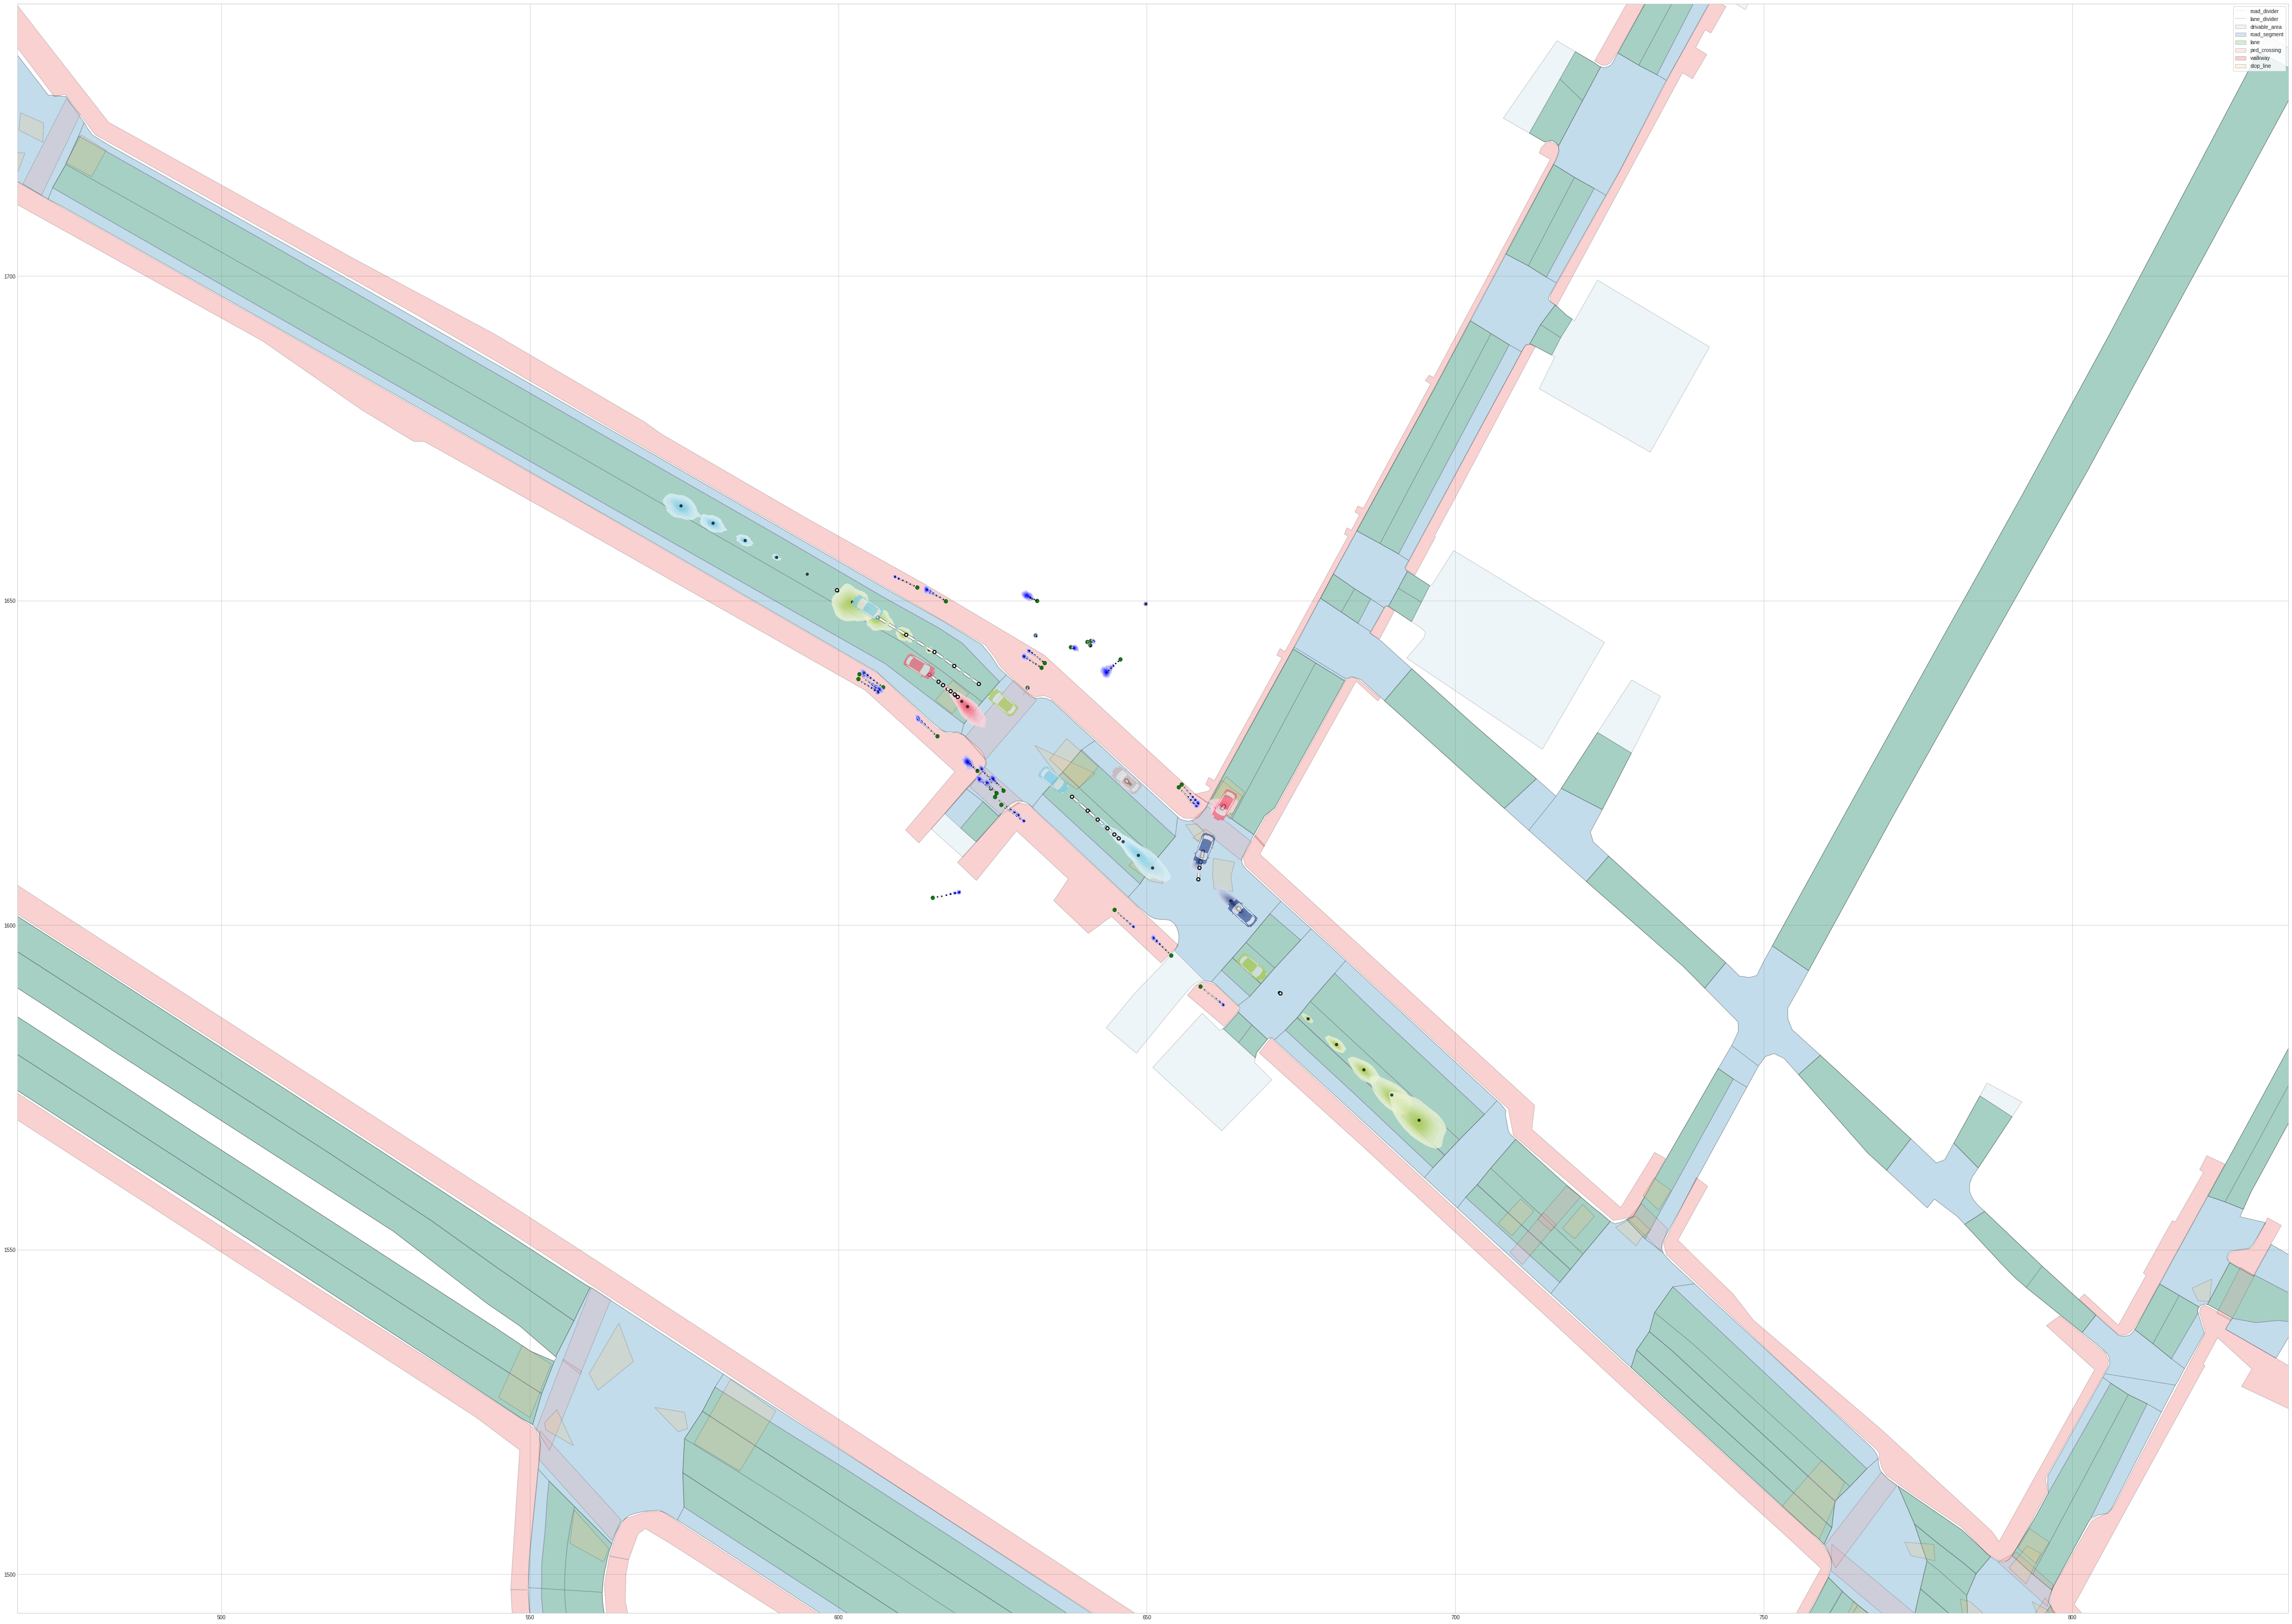

In [5]:
for i, ts in enumerate(timesteps):
    fig, ax = nusc_map.render_map_patch(patch, layers, figsize=(60, 50), alpha=0.2, render_egoposes_range=False)
    plot_vehicle_nice(ax,
                      {ts: predictions[ts]},
                      scene.dt,
                      max_hl=10,
                      ph=ph,
                      map=None, x_min=x_min, y_min=y_min)

    plot_vehicle_mm(ax,
                    {ts: predictions_mm[ts]},
                    scene.dt,
                    max_hl=10,
                    ph=ph,
                    map=None, x_min=x_min, y_min=y_min)

    ax.set_title(f"{scene.name} - timestep: {ts}")
    fig.show()
    log_writer.add_figure(scene.name, fig, ts)

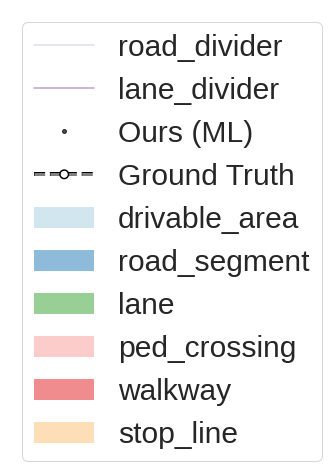

In [24]:
my_patch = (0, 0, 1, 1)
fig, ax = nusc_map.render_map_patch(my_patch, layers, figsize=(1, 1), alpha=0.1, render_egoposes_range=False)
ax.plot([], [], 'ko',
            zorder=620,
            markersize=4,
            linewidth=2, alpha=0.7, label='Ours (ML)')

ax.plot([],
        [],
        'w--o', label='Ground Truth',
        linewidth=3,
        path_effects=[pe.Stroke(linewidth=4, foreground='k'), pe.Normal()])
leg = ax.legend(loc='upper left', fontsize=30, frameon=True)
for lh in leg.legendHandles:
    lh.set_alpha(.5)
ax.axis('off')
ax.grid('off')
fig.savefig('/home/t/thanh/output/plots/qual_nuScenes_legend.pdf', dpi=300, bbox_inches='tight')